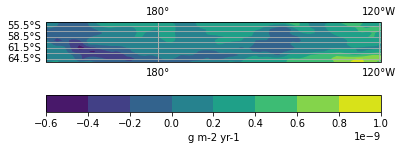

In [198]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import iris.analysis.cartography
import iris.plot as iplt
import iris.quickplot as qplt
import numpy as np
import matplotlib.ticker as mticker 
from numpy import *
from matplotlib.pyplot import *
from iris.analysis import *
from iris.coord_categorisation import * 
from iris.analysis.cartography import * 
from scipy.stats import *
from scipy.stats.mstats import *
from iris import *

import warnings
warnings.filterwarnings("ignore")



fgname = ('/Users/alicebrindley/Downloads/GFDL-ESM-pi-control-fgco2/outfile')
fgcube = iris.load(fgname)
fgcube1=fgcube[0] 

#extract Jan and Dec to average the sea ice concentration across these mon
add_month_number(fgcube1, 'time', name='month_number1')
fgcube2 = fgcube1[np.where((fgcube1.coord('month_number1').points == 12))]
#then to average this by each year, so that you have the December-Jan for
add_season_year(fgcube2, 'time', name='season_year')
#then average by the season year:
fgcube2.aggregated_by(['season_year'], iris.analysis.MEAN)
#cube2 is therefore the data per season


# Extract the regionan of interst across teh whole cube just once at that start
west = -210 
east = -120 
south = -65
north = -55



fg_temporary_cube = fgcube2.intersection(longitude = (west, east)) 
fgcube3 = fg_temporary_cube.intersection(latitude = (south, north))


ax1 = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=np.round(west + (east - west)/2.0))) 
my_plot = iplt.contourf(fgcube3[0,:,:])
plt.gca().gridlines(draw_labels=True)
plt.colorbar(orientation='horizontal', label='g m-2 yr-1')



NameError: name 'masked_co2_flux' is not defined

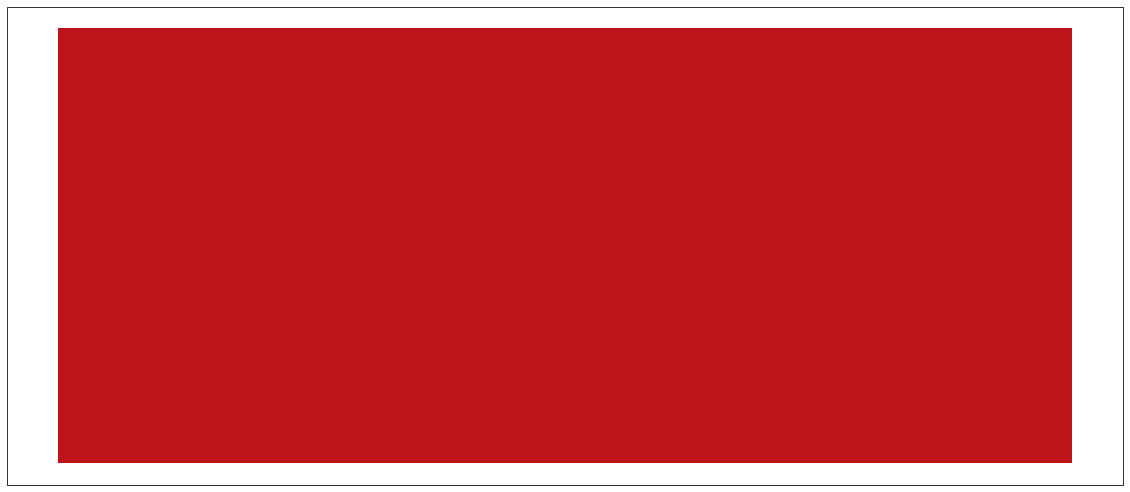

In [7]:
 # adding this so that I can add colour to the land and make sure everything make sense
import cartopy.feature as cfeature # Which time step to plot?

time_slice = 1
plt.figure(figsize=(20,20))
ax1 = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=np.round(west + (east - west)/2.0))) # 
my_plot = iplt.pcolormesh(fgcube2[time_slice],cmap='Reds',vmin=-3.0,vmax=2.0e-8)
my_plot = iplt.pcolormesh(polynya_location_cube[time_slice],cmap='Reds',vmin=-3.0,vmax=2.0)
my_plot = iplt.pcolormesh(masked_co2_flux[time_slice],cmap='Reds',vmin=0.0,vmax=1.0e-8) 
plt.gca().gridlines(draw_labels=True)
# Adding shading for land and coastline
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)
# adding a colourbar so I can see what the values are
plt.colorbar(orientation='horizontal')
plt.savefig('open_ocean_carbon_flux.png')

In [199]:
def area_avg(cube): 
    try:
        cube.coord('latitude').guess_bounds() 
    except:
        pass 
    try:
        cube.coord('longitude').guess_bounds() 
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude', 'latitude'],iris.analysis.MEAN, weights=grid_areas)

In [200]:
masked_co2_flux_timeseries = area_avg(fgcube2*31536000000)

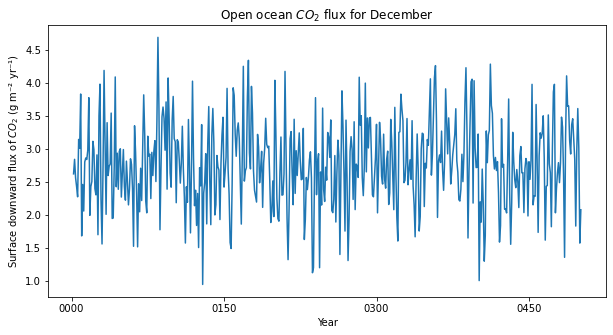

In [203]:
plt.figure(figsize=(10,5)) 
iplt.plot(masked_co2_flux_timeseries) 
plt.title('Open ocean $CO_2$ flux for December')

plt.ylabel('Surface downward flux of $CO_2$ (g m⁻² yr⁻¹)') 
plt.xlabel('Year')
plt.savefig('open_ocean_flux_december')




In [204]:
print(np.mean(masked_co2_flux_timeseries.data))

2.769931561808786


In [ ]:
#Make a 3D copy of the input cube to hold teh output
polynya_location_cube = cube2.copy()
#have a variable holding just the data from this into which we can push teh processed data
polynya_location_cube_data = polynya_location_cube.data
#not just set that all to missing data (nans) so that we know if we have data in it it is real data we want not just leftovers.
polynya_location_cube_data[:] = np.nan

#start of the loop
for i in range (0,2101-2015):
    regional_cube=cube2[i,:,:]
    ax1 = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=np.round(west + (east - west)/2.0)))
    my_plot = iplt.contourf(regional_cube)
    plt.gca().gridlines(draw_labels=True)
    plt.show()


    grid_areas = area_weights(regional_cube)
    average_variable = regional_cube.collapsed(['latitude', 'longitude'],MEAN,weights=grid_areas)
    print(average_variable.data)
    #north_edge = regional_cube.extract(iris.Constraint(latitude=[-72,-72.5,-73,-73.5,-74,-74.5,-75,-75.5,-76]))
    #average across this latitude
    #nE_mean = north_edge.collapsed('longitude', iris.analysis.MEAN)
    #print(nE_mean)
 
    if average_variable.data>= 0:
        #define siconc for polynya
        polynya_threshold=regional_cube.data
        polynya = np.where(polynya_threshold.data >=0)
        #print(polynya)
        polynya = polynya_threshold.data
        #plt.pcolormesh(polynya_threshold.data,vmin=0,vmax=100)
        plt.show()

        #define a variable to hold the threshold number you are interested in
        polynya_threshold_value = 0.0
        #Take a copy of the seaice data that we are going to use to make a binary 'mask' showing presence of absense of polynyas as 1s and 0s
        polynya_location = polynya_threshold.data.copy()
        #set that land data in this mask to nan (Not a number) so we don;t get confused (these will show up white in a typical plot)
        polynya_location[np.where(polynya_location >= 1.0e9)] = np.nan
        #make water that has more ice than our polynia condition equal to zero.
        polynya_location[np.where((polynya_location <= 100.0))] = 1.0
        #make water that has less ice than our polynia condition equal to zero to make where the polynya is
        #polynya_location[np.where((polynya_location > 0.0) & (polynya_location <= polynya_threshold_value))] = 1.0
        
        #Assign the data to that particular year in the 3D output array:
        polynya_location_cube_data[i,:,:] = polynya_location
        
        #plot this data
        plt.pcolormesh(polynya_location,vmin=0,vmax=1)
        
        plt.show()
        
#Put th polynia data array nack in to the cube wich holds al o fteh metadata etc.
polynya_location_cube.data = polynya_location_cube_data